In [3]:
import os
os.chdir('../')

In [4]:
%load_ext autoreload  
%autoreload 2

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from torchvision import transforms as T
from analysis.image import show_image
from datamodules.datasets import get_datasets
from torchinfo import summary
from easydict import EasyDict as edict
from tqdm import tqdm
from datamodules import DINOV2FeaturesDataModule
from sklearn.metrics.pairwise import cosine_similarity
from experiment import VAEXperiment
from classification import Classifier

from sklearn.manifold import TSNE

# suppress user warnings
import warnings
warnings.filterwarnings('ignore')

# Datasets

In [42]:
IMAGENET_MEAN, IMAGENET_STD = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

DATASETS = get_datasets(
    root='/home/nazir/datasets',
    transforms=edict(
        CIFAR10=T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ]),
        CELEBA=T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ]),
        OMNIGLOT=T.Compose([
            T.ToTensor(),
            T.Lambda(lambda x: x.repeat(3, 1, 1)),
            T.Resize((224, 224)),
            T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        ]),
    )
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: /home/nazir/datasets/test_32x32.mat
Files already downloaded and verified
Files already downloaded and verified


# Loading the Model


In [13]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14', pretrained=True)

Using cache found in /home/nazir/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [14]:
_ = dinov2_vits14.eval()
_ = dinov2_vits14.cuda()

# Initial Tests

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


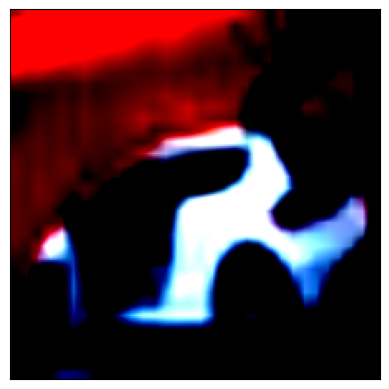

In [14]:
x, y = DATASETS.CIFAR10[6]

show_image(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


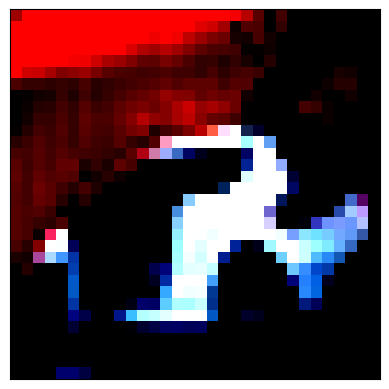

In [16]:
x_resized = F.interpolate(x.unsqueeze(0), size=(32, 32), mode='bilinear', align_corners=False)

show_image(x_resized.squeeze(0))

In [11]:
with torch.no_grad():
    output = dinov2_vits14.forward_features(x.unsqueeze(0).cuda())

In [12]:
output.keys()

dict_keys(['x_norm_clstoken', 'x_norm_patchtokens', 'x_prenorm', 'masks'])

In [13]:
output['x_prenorm'].shape, output['x_norm_patchtokens'].shape, output['x_norm_clstoken'].shape

(torch.Size([1, 257, 384]), torch.Size([1, 256, 384]), torch.Size([1, 384]))

In [18]:
avg_pool = nn.AvgPool1d(kernel_size=2, stride=2)

out = avg_pool(output['x_norm_patchtokens'].squeeze(0).permute(1, 0))

out.shape

torch.Size([384, 128])

# Utils

In [15]:
def get_features(model, x, features_type="x_prenorm"):
    with torch.no_grad():
        output = model.forward_features(x.unsqueeze(0).cuda())
    return output[features_type].squeeze(0).cpu().numpy()

# Visualization of Features on CIFAR10

## CLS Token

In [9]:
cls_features = []
labels = []
for i in tqdm(range(len(DATASETS.CIFAR10))):
    x, y = DATASETS.CIFAR10[i]
    features = get_features(dinov2_vits14, x, features_type="x_norm_clstoken")
    labels.extend([y])
    cls_features.extend([features])

cls_features = np.array(cls_features)
labels = np.array(labels)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:57<00:00, 173.40it/s]


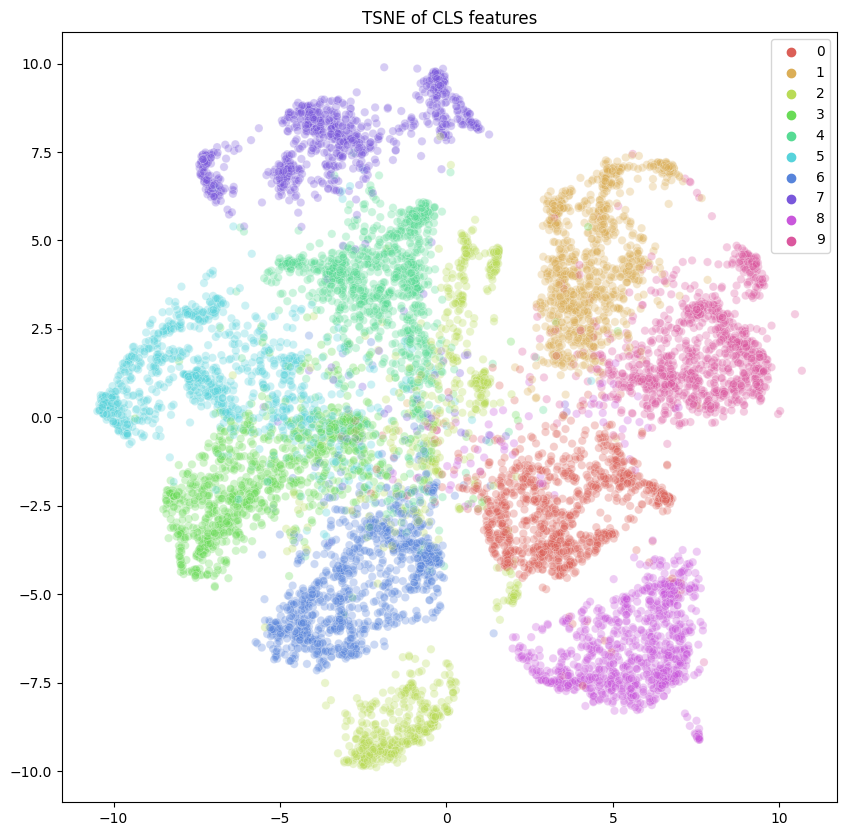

In [10]:
# extract and plot tsne of cls_features

tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(cls_features)

tsne_results.shape

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=labels,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
plt.title("TSNE of CLS features")
plt.show()

## Patch Features Prenorm

patch features are averaged

In [11]:
patch_features_prenorm = []
for i in tqdm(range(len(DATASETS.CIFAR10))):
    x, y = DATASETS.CIFAR10[i]
    features = get_features(dinov2_vits14, x, features_type="x_prenorm")
    patch_features_prenorm.extend([features.mean(axis=0)])

patch_features_prenorm = np.array(patch_features_prenorm)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:59<00:00, 166.76it/s]


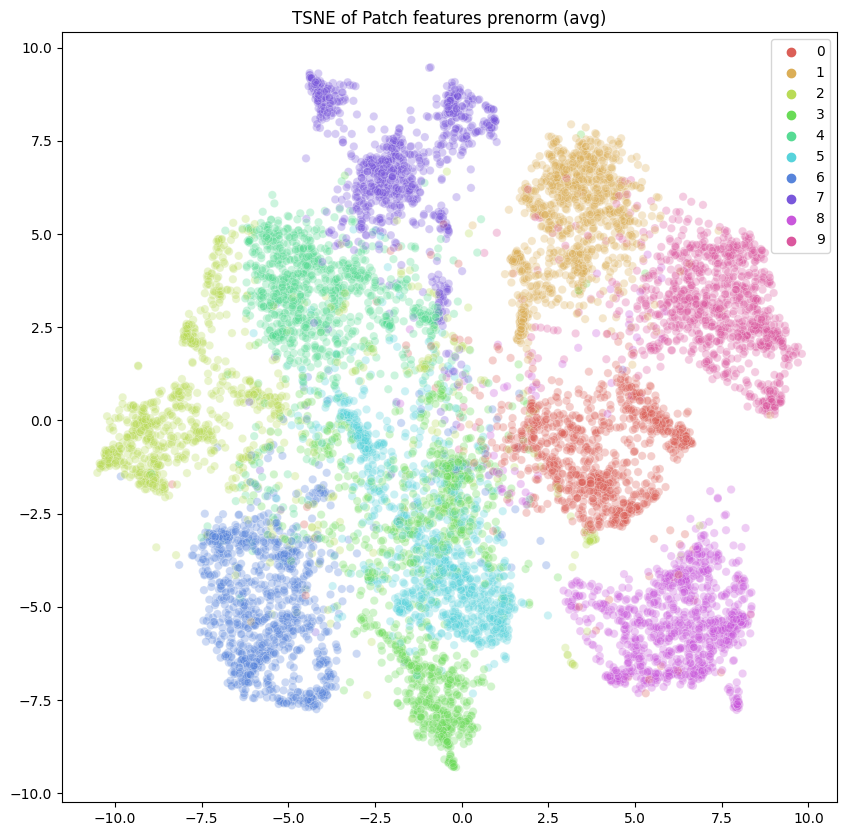

In [12]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results_patch_prenorm = tsne.fit_transform(patch_features_prenorm)

tsne_results.shape

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=tsne_results_patch_prenorm[:, 0], y=tsne_results_patch_prenorm[:, 1],
    hue=labels,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
plt.title("TSNE of Patch features prenorm (avg)")
plt.show()

## Patch Features Post-Norm

patch features are averaged

In [13]:
patch_features_norm = []
for i in tqdm(range(len(DATASETS.CIFAR10))):
    x, y = DATASETS.CIFAR10[i]
    features = get_features(dinov2_vits14, x, features_type="x_norm_patchtokens")
    patch_features_norm.extend([features.mean(axis=0)])

patch_features_norm = np.array(patch_features_norm)

100%|██████████| 10000/10000 [00:59<00:00, 168.18it/s]


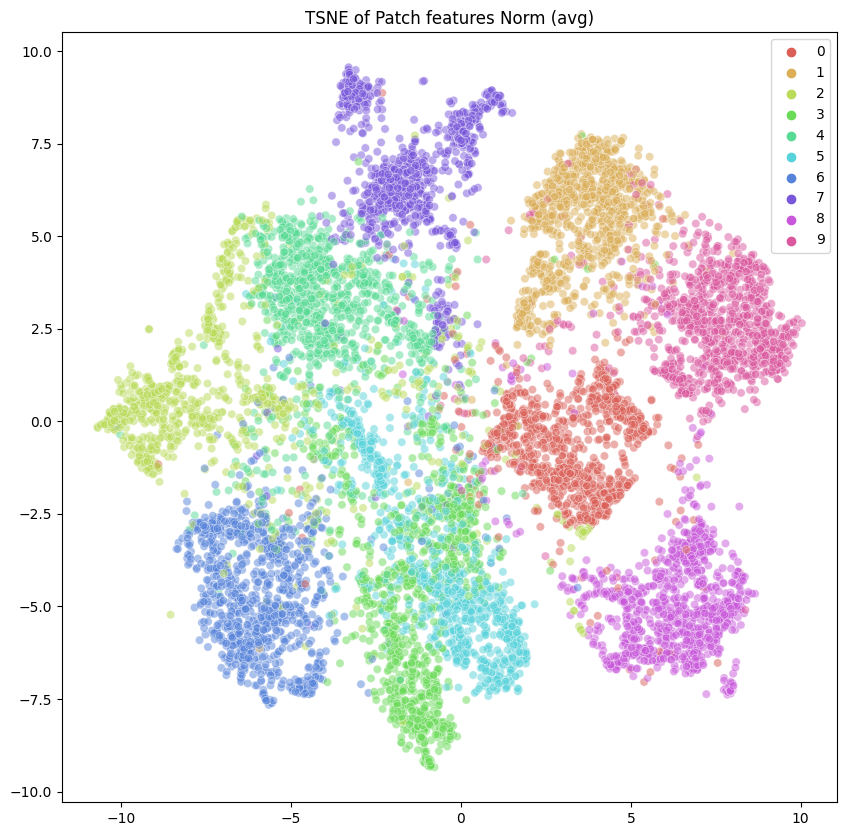

In [14]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results_patch_norm = tsne.fit_transform(patch_features_norm)

tsne_results.shape

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=tsne_results_patch_norm[:, 0], y=tsne_results_patch_norm[:, 1],
    hue=labels,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.5
)
plt.title("TSNE of Patch features Norm (avg)")
plt.show()

# CIFAR vs Other Datasets

In [28]:
# extract CLS features from CELEBA dataset and plot CELBA vs CIFAR10 tsne

cls_features_celeba = []
for i in tqdm(range(min(len(DATASETS.CELEBA), 10000))):
    x, y = DATASETS.CELEBA[i]
    features = get_features(dinov2_vits14, x, features_type="x_norm_clstoken")
    cls_features_celeba.extend([features])

cls_features_celeba = np.array(cls_features_celeba)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:02<00:00, 160.41it/s]


In [40]:
# extract CLS features from omniglot, SVHN, and CIFAR100 datasets, with 10000 samples at most from each

cls_features_omniglot = []
for i in tqdm(range(min(len(DATASETS.OMNIGLOT), 10000))):
    x, y = DATASETS.OMNIGLOT[i]
    features = get_features(dinov2_vits14, x, features_type="x_norm_clstoken")
    cls_features_omniglot.extend([features])

cls_features_omniglot = np.array(cls_features_omniglot)

cls_features_svhn = []
for i in tqdm(range(min(len(DATASETS.SVHN), 10000))):
    x, y = DATASETS.SVHN[i]
    features = get_features(dinov2_vits14, x, features_type="x_norm_clstoken")
    cls_features_svhn.extend([features])

cls_features_svhn = np.array(cls_features_svhn)

cls_features_cifar100 = []

for i in tqdm(range(min(len(DATASETS.CIFAR100), 10000))):

    x, y = DATASETS.CIFAR100[i]
    features = get_features(dinov2_vits14, x, features_type="x_norm_clstoken")
    cls_features_cifar100.extend([features])

cls_features_cifar100 = np.array(cls_features_cifar100)

100%|██████████| 10000/10000 [00:58<00:00, 170.45it/s]


In [41]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)

tsne_cifar10_vs_celeba = tsne.fit_transform(np.concatenate([
    cls_features, 
    cls_features_celeba,
    cls_features_omniglot,
    cls_features_svhn,
    cls_features_cifar100
]))

In [42]:
labels_cifar10_vs_celeba = np.array(
    ["CIFAR 10"] * len(cls_features) + \
    ["CelebA"] * len(cls_features_celeba) + \
    ["Omniglot"] * len(cls_features_omniglot) + \
    ["SVHN"] * len(cls_features_svhn) + \
    ["CIFAR 100"] * len(cls_features_cifar100)
)

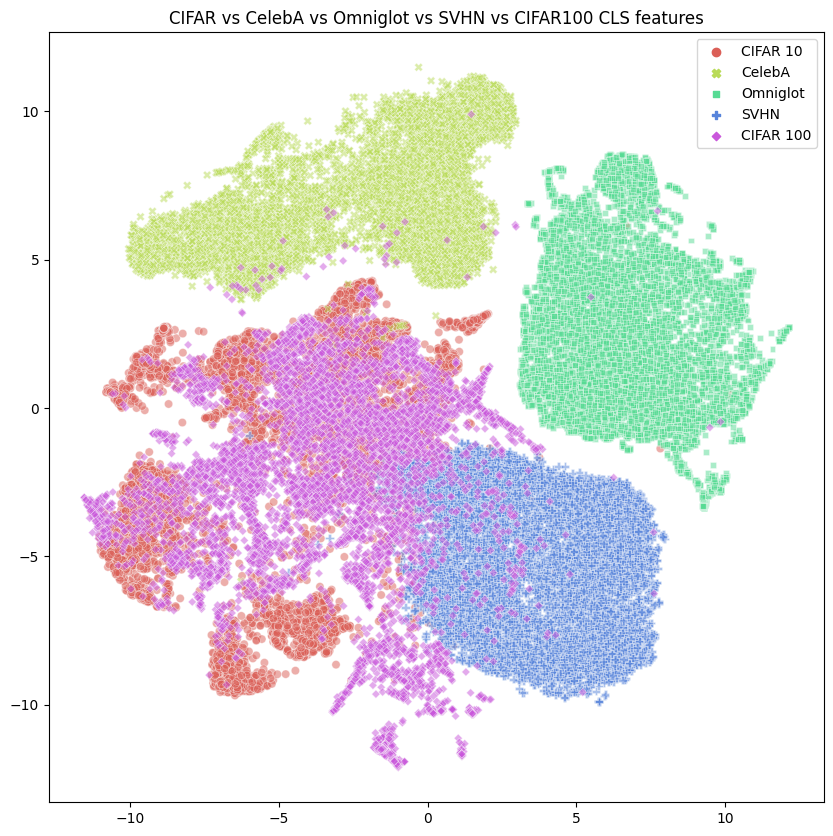

In [44]:
plt.figure(figsize=(10, 10))
# add legend names CIFAR10 as 0 and CELEBA as 1
sns.scatterplot(
    x=tsne_cifar10_vs_celeba[:, 0], y=tsne_cifar10_vs_celeba[:, 1],
    hue=labels_cifar10_vs_celeba,
    palette=sns.color_palette("hls", 5),
    legend="full",
    alpha=0.5,
    style=labels_cifar10_vs_celeba
)
plt.title("CIFAR vs CelebA vs Omniglot vs SVHN vs CIFAR100 CLS features")
plt.show()

# Quantization of DINO features

In [8]:
x, y = DATASETS.CIFAR10[0]

features = get_features(dinov2_vits14, x, features_type="x_norm_clstoken")

/home/nazir/anaconda3/envs/vae_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


NameError: name 'get_features' is not defined

# Distance Based OoD Classification

In [18]:
# choose 10 random samples from each of the 10 classes of CIFAR10 training setas prototypes and compute L2 and cosine distances
# between the CIFAR10 test set and the prototypes, and also between CelebA and the prototypes

NUM_PROTO_PER_CLASS = 10

cifar10_prototypes = [[] for _ in range(10)]

for i in tqdm(range(len(DATASETS.CIFAR10_TRAIN)), desc="Searching for prototypes"):
    x, y = DATASETS.CIFAR10_TRAIN[i]
    if len(cifar10_prototypes[y]) < NUM_PROTO_PER_CLASS:
        cifar10_prototypes[y].extend([get_features(dinov2_vits14, x, features_type="x_norm_clstoken")])

cifar10_prototypes = np.array(cifar10_prototypes)

Searching for prototypes...:   0%|          | 0/50000 [00:00<?, ?it/s]

/home/nazir/anaconda3/envs/vae_env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Searching for prototypes...: 100%|██████████| 50000/50000 [00:20<00:00, 2482.25it/s]


In [44]:
# compute L2 and cosine distances between the CIFAR10 test set and the prototypes, 
# and also between CelebA and the prototypes

cifar10_l2_distances = []
cifar10_cosine_distances = []
celeba_l2_distances = []
celeba_cosine_distnaces = []

for i in tqdm(range(len(DATASETS.CIFAR10)), desc="CIFAR10"):
    x, y = DATASETS.CIFAR10[i]

    features = get_features(dinov2_vits14, x, features_type="x_norm_clstoken")
    features = features.reshape(1, -1).repeat(NUM_PROTO_PER_CLASS, axis=0)
   
    l2_dist = np.zeros(10)
    cosine_dist = np.zeros(10)
    for c in range(10):
        l2_dist[c] = np.linalg.norm(features - cifar10_prototypes[c])
        cosine_dist[c] =  1 - np.diag(cosine_similarity(features, cifar10_prototypes[c])).mean()

    cifar10_l2_distances.extend([l2_dist.mean()])
    cifar10_cosine_distances.extend([cosine_dist.mean()])

for i in tqdm(range(len(DATASETS.CELEBA)), desc="CELEBA"):
    x, y = DATASETS.CELEBA[i]

    features = get_features(dinov2_vits14, x, features_type="x_norm_clstoken")
    features = features.reshape(1, -1).repeat(NUM_PROTO_PER_CLASS, axis=0)
    
    l2_dist = np.zeros(10)
    cosine_dist = np.zeros(10)
    for c in range(10):
        l2_dist[c] = np.linalg.norm(features - cifar10_prototypes[c])
        cosine_dist[c] =  1 - np.diag(cosine_similarity(features, cifar10_prototypes[c])).mean()

    celeba_l2_distances.extend([l2_dist.mean()])
    celeba_cosine_distnaces.extend([cosine_dist.mean()])


CELEBA: 100%|██████████| 19867/19867 [02:55<00:00, 113.28it/s]


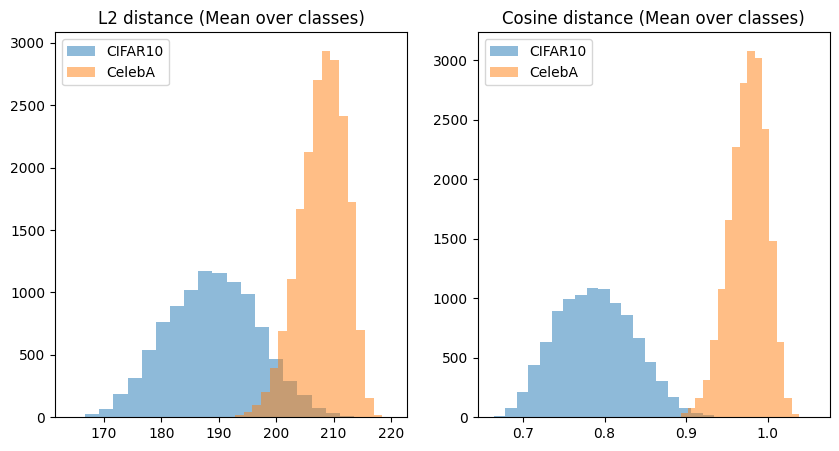

In [46]:
# plot histograms of distances comparing CIFAR10 and CELEBA for both L2 and cosine distances

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(cifar10_l2_distances, bins=20, alpha=0.5, label="CIFAR10")
plt.hist(celeba_l2_distances, bins=20, alpha=0.5, label="CelebA")
plt.title("L2 distance (Mean over classes)")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(cifar10_cosine_distances, bins=20, alpha=0.5, label="CIFAR10")
plt.hist(celeba_cosine_distnaces, bins=20, alpha=0.5, label="CelebA")
plt.title("Cosine distance (Mean over classes)")
plt.legend()
plt.show()


In [48]:
# compute cosine and l2 distances between cifar10 and cifar100

cifar100_l2_distances = []
cifar100_cosine_distances = []

for i in tqdm(range(len(DATASETS.CIFAR100)), desc="CIFAR100"):

    x, y = DATASETS.CIFAR100[i]

    features = get_features(dinov2_vits14, x, features_type="x_norm_clstoken")
    features = features.reshape(1, -1).repeat(NUM_PROTO_PER_CLASS, axis=0)
    
    l2_dist = np.zeros(10)
    cosine_dist = np.zeros(10)
    for c in range(10):
        l2_dist[c] = np.linalg.norm(features - cifar10_prototypes[c])
        cosine_dist[c] =  1 - np.diag(cosine_similarity(features, cifar10_prototypes[c])).mean()

    cifar100_l2_distances.extend([l2_dist.mean()])
    cifar100_cosine_distances.extend([cosine_dist.mean()])

CIFAR100: 100%|██████████| 10000/10000 [01:20<00:00, 124.51it/s]


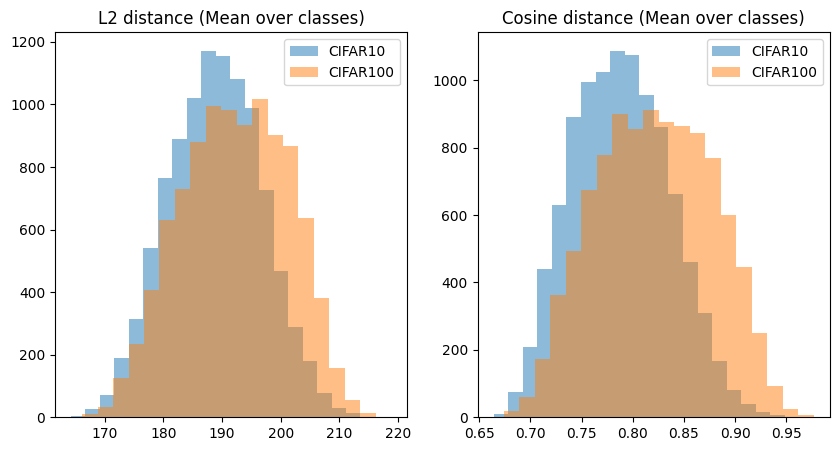

In [49]:
# plot histogram comparing CIFAR10 and CIFAR100 for both L2 and cosine distances

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(cifar10_l2_distances, bins=20, alpha=0.5, label="CIFAR10")
plt.hist(cifar100_l2_distances, bins=20, alpha=0.5, label="CIFAR100")
plt.title("L2 distance (Mean over classes)")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(cifar10_cosine_distances, bins=20, alpha=0.5, label="CIFAR10")
plt.hist(cifar100_cosine_distances, bins=20, alpha=0.5, label="CIFAR100")
plt.title("Cosine distance (Mean over classes)")
plt.legend()
plt.show()


# Classifier Analysis

In [57]:
ckpt_path = "model_logs/classifier/mlp/Codebook/mlp_vectors_dinov2_features/epoch=13-val_loss_epoch=0.22.ckpt"
cls_ckpt = torch.load(ckpt_path, map_location="cpu")
cls_hparams = edict(cls_ckpt["hyper_parameters"])

classifier = Classifier(cls_hparams)
classifier.load_state_dict(cls_ckpt["state_dict"])
_ = classifier.cuda()
_ = classifier.eval()

vq_vae_ckpt = torch.load(cls_hparams.DATA.VQ_VAE_PATH)
vq_vae_hparams = edict(vq_vae_ckpt["hyper_parameters"])
vq_vae = VAEXperiment(vq_vae_hparams)
vq_vae.load_state_dict(vq_vae_ckpt["state_dict"])
vq_vae = vq_vae.model
_ = vq_vae.eval()
_ = vq_vae.cuda()

In [68]:
x, y = DATASETS.CIFAR10[0]

with torch.no_grad():

    features = get_features(dinov2_vits14, x, features_type="x_prenorm")
    features = torch.from_numpy(features)
    N, C = features.shape
    N = N - 1
    N_sqrt = int(np.sqrt(N))
    features = features[1:].permute(1, 0).view(C, N_sqrt, N_sqrt)
    codebook_outputs = vq_vae.vq(vq_vae.pre_vq_conv(vq_vae.encoder(features.unsqueeze(0).cuda())))
    quantized = codebook_outputs.quantized.squeeze()
    C, H, W = quantized.shape
    quantized = quantized.view(C, H * W).permute(1, 0).reshape(-1)  
    cls_out = classifier(quantized.unsqueeze(0))

cls_out.squeeze().shape

torch.Size([2])

In [69]:
cifar10_scores = []
cifar100_scores = []

for i in tqdm(range(len(DATASETS.CIFAR10)), desc="CIFAR10"):
    x, y = DATASETS.CIFAR10[i]

    with torch.no_grad():

        features = get_features(dinov2_vits14, x, features_type="x_prenorm")
        features = torch.from_numpy(features)
        N, C = features.shape
        N = N - 1
        N_sqrt = int(np.sqrt(N))
        features = features[1:].permute(1, 0).view(C, N_sqrt, N_sqrt)
        codebook_outputs = vq_vae.vq(vq_vae.pre_vq_conv(vq_vae.encoder(features.unsqueeze(0).cuda())))
        quantized = codebook_outputs.quantized.squeeze()
        C, H, W = quantized.shape
        quantized = quantized.view(C, H * W).permute(1, 0).reshape(-1)  
        cls_out = classifier(quantized.unsqueeze(0)).squeeze()
        
        cifar10_scores.append(cls_out[1].cpu().numpy())
    
for i in tqdm(range(len(DATASETS.CIFAR100)), desc="CIFAR100"):
    x, y = DATASETS.CIFAR100[i]
    with torch.no_grad():

        features = get_features(dinov2_vits14, x, features_type="x_prenorm")
        features = torch.from_numpy(features)
        N, C = features.shape
        N = N - 1
        N_sqrt = int(np.sqrt(N))
        features = features[1:].permute(1, 0).view(C, N_sqrt, N_sqrt)
        codebook_outputs = vq_vae.vq(vq_vae.pre_vq_conv(vq_vae.encoder(features.unsqueeze(0).cuda())))
        quantized = codebook_outputs.quantized.squeeze()
        C, H, W = quantized.shape
        quantized = quantized.view(C, H * W).permute(1, 0).reshape(-1)  
        cls_out = classifier(quantized.unsqueeze(0)).squeeze()
        
        cifar100_scores.append(cls_out[1].cpu().numpy())

CIFAR100: 100%|██████████| 10000/10000 [01:17<00:00, 129.78it/s]


In [73]:
celeba_scores = []

for i in tqdm(range(len(DATASETS.CELEBA)), desc="CELEBA"):
    x, y = DATASETS.CELEBA[i]
    with torch.no_grad():

        features = get_features(dinov2_vits14, x, features_type="x_prenorm")
        features = torch.from_numpy(features)
        N, C = features.shape
        N = N - 1
        N_sqrt = int(np.sqrt(N))
        features = features[1:].permute(1, 0).view(C, N_sqrt, N_sqrt)
        codebook_outputs = vq_vae.vq(vq_vae.pre_vq_conv(vq_vae.encoder(features.unsqueeze(0).cuda())))
        quantized = codebook_outputs.quantized.squeeze()
        C, H, W = quantized.shape
        quantized = quantized.view(C, H * W).permute(1, 0).reshape(-1)  
        cls_out = classifier(quantized.unsqueeze(0)).squeeze()
        
        celeba_scores.append(cls_out[1].cpu().numpy())

CELEBA:   0%|          | 0/19867 [00:00<?, ?it/s]

CELEBA: 100%|██████████| 19867/19867 [02:57<00:00, 112.24it/s]


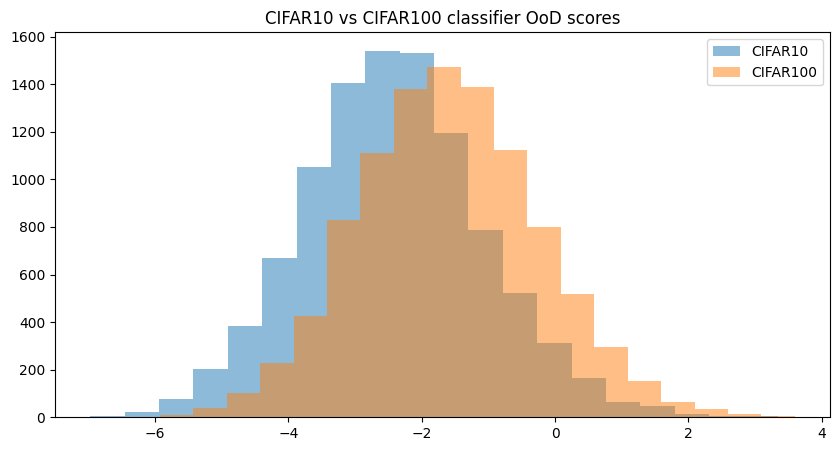

In [71]:
# plot histograms fo cifar10 vs cifar100 scores

plt.figure(figsize=(10, 5))
plt.hist(cifar10_scores, bins=20, alpha=0.5, label="CIFAR10")
plt.hist(cifar100_scores, bins=20, alpha=0.5, label="CIFAR100")
plt.title("CIFAR10 vs CIFAR100 classifier OoD scores")
plt.legend()
plt.show()

# plot histograms fo cifar10 vs cifar100 scores

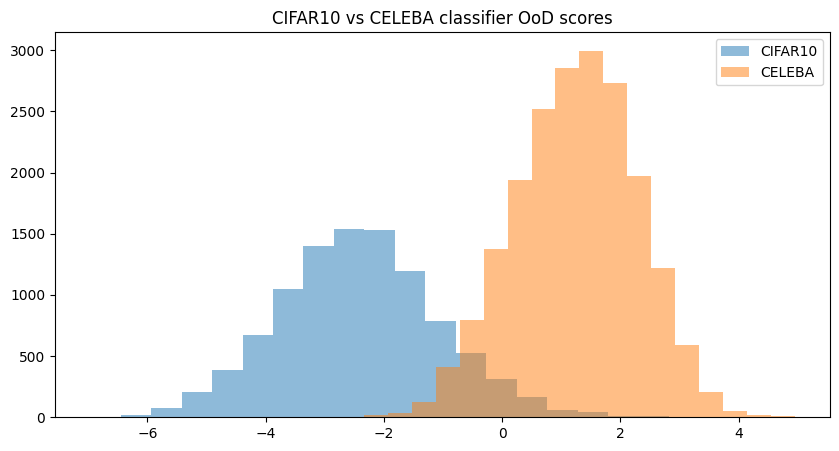

In [74]:
plt.figure(figsize=(10, 5))
plt.hist(cifar10_scores, bins=20, alpha=0.5, label="CIFAR10")
plt.hist(celeba_scores, bins=20, alpha=0.5, label="CELEBA")
plt.title("CIFAR10 vs CELEBA classifier OoD scores")
plt.legend()
plt.show()

# Data Loading

In [9]:
# read yaml file configs/vq_vae/dinov2_feature.yaml using py yaml

with open("configs/vq_vae/dinov2_features.yaml") as f:
    config = yaml.load(f,Loader=yaml.FullLoader)

config = edict(config)

datamodule = DINOV2FeaturesDataModule(config=config)
datamodule.prepare_data()
datamodule.setup()

Using cache found in /home/nazir/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


Data already exists at ./data/dinov2/CIFAR10/train. Skipping data generation.
Data already exists at ./data/dinov2/CIFAR10/test. Skipping data generation.


In [10]:
train_dataset = datamodule.train_dataset

len(train_dataset)

50000

In [11]:
x, y = train_dataset[0]

x.shape

torch.Size([384, 16, 16])